In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter
plt.style.use('ggplot')
import seaborn as sns
pd.options.display.float_format = '{:,.0f}'.format
from IPython.display import display
import dataframe_image as dfi
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
encoder = OneHotEncoder(sparse_output=False)
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn import ensemble
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
import shap
import warnings
warnings.filterwarnings('ignore')
import ipywidgets as widgets
#widgets.IntSlider()

In [2]:
#Import Imputeed Ames Data
Ames = pd.read_csv('Ames_HousePrice_Engineered.csv')

#Update with new Ames Data
Ames_Columns_Numeric = Ames[[
    '1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtFinSF1', 'BsmtFinSF2',
    'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF', 'EnclosedPorch', 'Fireplaces', 'FullBath',
    'GarageArea', 'GarageCars', 'GarageYrBlt', 'GrLivArea', 'HalfBath', 'KitchenAbvGr',
    'LotArea', 'LotFrontage', 'LowQualFinSF', 'MasVnrArea', 'MiscVal', 'MoSold',
    'OpenPorchSF', 'PoolArea', 'ScreenPorch', 'TotalBsmtSF', 'TotRmsAbvGrd', 'WoodDeckSF',
    'YearBuilt', 'YearRemodAdd', 'YrSold', 'Living_Area_%of_Lot', 'Lot_Frontage_%', 'Home_Age',
    'Yrs_Since_Remodel', '1stFlr_%of_Living_Area', 'Interior_Area_%of_Lot', 'Total_Bathrooms_prorated',
    'Kitchens_prorated', 'OverallQual_weighted', 'ExterQual_weighted', 'GarageArea_prorated', 'BsmtArea_prorated'
]]
Ames_Columns_Ordinal = Ames[[ 
    'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual',
    'Electrical', 'ExterCond', 'ExterQual', 'Fence', 'FireplaceQu', 'Functional',
    'GarageCond', 'GarageFinish', 'GarageQual', 'HeatingQC', 'KitchenQual',
    'LandSlope', 'LotShape', 'OverallCond', 'OverallQual', 'PavedDrive',
    'PoolQC', 'Utilities'
]]
Ames_Columns_Nominal = Ames[[ 
    'Alley', 'BldgType', 'CentralAir', 'Condition1', 'Condition2',
    'Exterior1st', 'Exterior2nd', 'Foundation', 'GarageType', 'Heating',
    'HouseStyle', 'LandContour', 'LotConfig', 'MasVnrType', 'MiscFeature',
    'MSSubClass', 'MSZoning', 'Neighborhood', 'RoofMatl', 'RoofStyle',
    'SaleCondition', 'SaleType', 'Street'
]].astype(str)

#Combination Table of Numeric & Ordinal Columns
Ames_Columns_Numeric_Ordinal = Ames[
    list(Ames_Columns_Numeric.columns) + list(Ames_Columns_Ordinal.columns)
]
#Combination Table of Nominal & Ordinal Columns
Ames_Columns_Nominal_Ordinal = Ames[
    list(Ames_Columns_Nominal.columns) + list(Ames_Columns_Ordinal.columns)
]

In [3]:
encoder = OneHotEncoder(sparse_output=False)
encoder_nominal = OneHotEncoder(sparse_output=False)
encoder_ordinal = OneHotEncoder(sparse_output=False)
Nominal_cols = Ames_Columns_Nominal.columns
Ordinal_cols = Ames_Columns_Ordinal.columns
Numeric_cols = Ames_Columns_Numeric.columns

#One-Hot Encode Nominal
Ames_Optimal_Nominal_One_Hot = encoder_nominal.fit_transform(Ames[Nominal_cols])
Ames_Optimal_Nominal_One_Hot_df = pd.DataFrame(
    Ames_Optimal_Nominal_One_Hot,
    columns=encoder_nominal.get_feature_names_out(Nominal_cols),
    index=Ames.index
)
#DO NOT One-Hot Encode Ordinal (for now)
Ames_Optimal_Ordinal_One_Hot = Ames_Columns_Ordinal #encoder_ordinal.fit_transform(Ames[Ordinal_cols])
Ames_Optimal_Ordinal_One_Hot_df = pd.DataFrame(
    Ames_Optimal_Ordinal_One_Hot,
    #columns=encoder_ordinal.get_feature_names_out(Ordinal_cols),
    index=Ames.index
)
#Merge Nominal & Ordinal Encodings
Ames_Optimal_Categorical_One_Hot = pd.merge(
    Ames_Optimal_Nominal_One_Hot_df,
    Ames_Optimal_Ordinal_One_Hot_df,
    left_index=True,
    right_index=True,
    how='left'
)
#Merge with Numeric Features
Ames_MLR_Optimal_Columns = pd.merge(
    Ames[Numeric_cols],
    Ames_Optimal_Categorical_One_Hot,
    left_index=True,
    right_index=True,
    how='left'
)

In [4]:
Y = Ames['SalePrice']
X = Ames_MLR_Optimal_Columns

In [5]:
def Plot_Feature_SHAP_Importances(model, model_name, X=X, top_n=20, use_all_rows=True, max_estimators=20):
    pd.options.display.float_format = None
    best_model = model.best_estimator_ if hasattr(model, 'best_estimator_') else model

    #--Feature Importances
    importances = None
    if hasattr(best_model, 'estimators_') and hasattr(best_model.estimators_[0], 'feature_importances_'):
        # Average feature importances over estimators (bagged models)
        if max_estimators < len(best_model.estimators_):
            selected_estimators = random.sample(best_model.estimators_, k=max_estimators)
        else:
            selected_estimators = best_model.estimators_
        importances = np.mean([est.feature_importances_ for est in selected_estimators], axis=0)
    elif hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_
    elif model_name.lower().startswith('cat') and hasattr(best_model, 'get_feature_importance'):
        importances = best_model.get_feature_importance()
    #Normalize Feature Importances for all models (XGBoost, LightGBM, Catboost not normalized by default)
    if importances is None:
        print(f'{model_name} does not expose feature importances')
        feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': np.nan})
    else:
        importances = np.array(importances, dtype=float)
        importances_total = importances.sum()
        if importances_total != 0 and not np.isnan(importances_total):
            importances = importances / importances_total
        else:
            print(f'{model_name} feature importances could not be normalized')
        feature_importance_df = (
            pd.DataFrame({'Feature': X.columns, 'Importance': np.round(importances, 4)}).sort_values('Importance', ascending=False)
            .reset_index(drop=True)
        )
        
    #--SHAP Values
    X_sample = X.copy() if use_all_rows else X.sample(min(500, X.shape[0]), random_state=2)
    try:
        if hasattr(best_model, 'estimators_'):
            if max_estimators < len(best_model.estimators_):
                selected_estimators = random.sample(best_model.estimators_, k=max_estimators)
                temp_model = best_model.__class__(base_estimator=best_model.estimators_[0],
                                                  n_estimators=max_estimators)
                temp_model.estimators_ = selected_estimators
                explainer = shap.TreeExplainer(temp_model)
            else:
                explainer = shap.TreeExplainer(best_model)
        elif hasattr(best_model, 'tree_') or 'Tree' in str(type(best_model)):
            explainer = shap.TreeExplainer(best_model)
        else:
            explainer = shap.Explainer(best_model, X_sample)
        shap_values = explainer(X_sample)
    except Exception:
        explainer = shap.Explainer(best_model.predict, X_sample)
        shap_values = explainer(X_sample)

    shap_vals = shap_values.values if hasattr(shap_values, 'values') else shap_values
    shap_abs_mean = np.abs(shap_vals).mean(axis=0)
    shap_value_df = (
        pd.DataFrame({'Feature': X_sample.columns, '|SHAP value|': shap_abs_mean})
        .sort_values('|SHAP value|', ascending=False)
    )

    #Merge Feature Importances and SHAP Values
    feature_shap_df = pd.merge(feature_importance_df, shap_value_df, on='Feature', how='outer')
    feature_shap_df = feature_shap_df.sort_values('Importance', ascending=False)

    #Side by Side Plots: Sorted by Feature Importance
    feature_shap_df_top = feature_shap_df.head(top_n)
    y_pos = np.arange(len(feature_shap_df_top))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, top_n * 0.5), sharey=True, dpi=600)
    ax1.barh(y_pos, feature_shap_df_top['Importance'], color='teal')
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(feature_shap_df_top['Feature'])
    ax1.invert_yaxis()
    ax1.set_xlabel('Feature Importance')
    ax1.set_title(f'{model_name} - Top {top_n} Feature Importances')
    ax1.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.2f}'))
    ax2.barh(y_pos, feature_shap_df_top['|SHAP value|'], color='blue')
    ax2.set_xlabel('|SHAP value| (Avg Impact)')
    ax2.set_title(f'{model_name} - SHAP Values')
    ax2.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.0f}'))
    plt.tight_layout()
    plt.show()

    #Side by Side Plots: Sorted by SHAP Value
    shap_feature_df_top = feature_shap_df.sort_values('|SHAP value|', ascending=False).head(top_n)
    y_pos_shap = np.arange(len(shap_feature_df_top))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, top_n * 0.5), sharey=True, dpi=600)
    ax1.barh(y_pos_shap, shap_feature_df_top['Importance'], color='teal')
    ax1.set_yticks(y_pos_shap)
    ax1.set_yticklabels(shap_feature_df_top['Feature'])
    ax1.invert_yaxis()
    ax1.set_xlabel('Feature Importance')
    ax1.set_title(f'{model_name} - Feature Importances')
    ax1.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.2f}'))
    ax2.barh(y_pos_shap, shap_feature_df_top['|SHAP value|'], color='blue')
    ax2.set_xlabel('|SHAP value| (Avg Impact)')
    ax2.set_title(f'{model_name} - Top {top_n} SHAP Feature Values')
    ax2.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.0f}'))
    plt.tight_layout()
    plt.show()

    #Beeswarm Plot
    print(f'\nSHAP Beeswarm Plot for {model_name}...')
    plt.figure(figsize=(100, max(6, top_n * 0.3)))
    shap.summary_plot(shap_values, X_sample, show=False, max_display=top_n)
    ax = plt.gca()
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.0f}'))
    ax.xaxis.set_major_locator(plt.MaxNLocator(6))
    ax.tick_params(axis='x', labelsize=11, rotation=0)
    xmin, xmax = ax.get_xlim()
    ax.set_xlim(xmin, xmax * 1.05)
    ax.set_xlabel('|SHAP value| (Average Impact on Model Output)', fontsize=13, labelpad=10)
    ax.set_title(f'{model_name} — SHAP Beeswarm Plot (Top {top_n} Features)', fontsize=14, pad=10)
    plt.tight_layout()
    plt.show()

    #Display
    display(feature_shap_df.head(top_n).style.format({'Importance': '{:.4f}', '|SHAP value|': '{:,.0f}'}))

In [6]:
def Plot_HGB_Feature_SHAP_Importances(model, X=X, Y=Y, top_n=20, use_all_rows=True, n_permutations=10):
    pd.options.display.float_format = None
    best_model = model.best_estimator_ if hasattr(model, 'best_estimator_') else model
    model_name = type(best_model).__name__

    #Permutation Feature Importances
    print(f'Calculating permutation importances for {model_name}...')
    perm_imp = permutation_importance(best_model, X, Y, n_repeats=n_permutations, random_state=2, n_jobs=-1)
    feature_importance_df = (
        pd.DataFrame({'Feature': X.columns, 'Importance': perm_imp.importances_mean})
        .sort_values('Importance', ascending=False)
    )

    #SHAP Values
    print(f'Calculating SHAP values for {model_name}...')
    X_sample = X.copy() if use_all_rows else X.sample(min(500, X.shape[0]), random_state=2)
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer(X_sample)
    shap_vals = shap_values.values if hasattr(shap_values, 'values') else shap_values
    shap_abs_mean = np.abs(shap_vals).mean(axis=0)

    shap_value_df = (
        pd.DataFrame({'Feature': X_sample.columns, '|SHAP value|': shap_abs_mean})
        .sort_values('|SHAP value|', ascending=False)
    )

    #Merge
    feature_shap_df = pd.merge(feature_importance_df, shap_value_df, on='Feature', how='outer')
    feature_shap_df = feature_shap_df.sort_values('Importance', ascending=False)

    #Side by Side Plots: Sorted by Feature Importances
    feature_shap_df_top = feature_shap_df.head(top_n).copy()
    y_pos = np.arange(len(feature_shap_df_top))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, top_n * 0.5), sharey=True, dpi=600)
    ax1.barh(y_pos, feature_shap_df_top['Importance'], color='teal')
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(feature_shap_df_top['Feature'])
    ax1.invert_yaxis()
    ax1.set_xlabel('Permutation Importance')
    ax1.set_title(f'{model_name} - Top {top_n} Permutation Importances')
    ax1.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.2f}'))
    ax2.barh(y_pos, feature_shap_df_top['|SHAP value|'], color='blue')
    ax2.set_xlabel('|SHAP value| (Avg Impact)')
    ax2.set_title(f'{model_name} - SHAP Values')
    ax2.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.0f}'))
    plt.tight_layout()
    plt.show()

    #Side by Side Plots: Sorted by SHAP Value
    shap_feature_df_top = feature_shap_df.sort_values('|SHAP value|', ascending=False).head(top_n)
    y_pos_shap = np.arange(len(shap_feature_df_top))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, top_n * 0.5), sharey=True, dpi=600)
    ax1.barh(y_pos_shap, shap_feature_df_top['Importance'], color='teal')
    ax1.set_yticks(y_pos_shap)
    ax1.set_yticklabels(shap_feature_df_top['Feature'])
    ax1.invert_yaxis()
    ax1.set_xlabel('Permutation Importance')
    ax1.set_title(f'{model_name} - Permutation Importances')
    ax1.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.2f}'))
    ax2.barh(y_pos_shap, shap_feature_df_top['|SHAP value|'], color='blue')
    ax2.set_xlabel('|SHAP value| (Avg Impact)')
    ax2.set_title(f'{model_name} - Top {top_n} SHAP Values')
    ax2.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.0f}'))
    plt.tight_layout()
    plt.show()

    #Beeswarm Plot
    print(f'\nSHAP Beeswarm Plot for {model_name}...')
    plt.figure(figsize=(100, max(6, top_n * 0.3)))
    shap.summary_plot(shap_values, X_sample, show=False, max_display=top_n)
    ax = plt.gca()
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.0f}'))
    ax.xaxis.set_major_locator(plt.MaxNLocator(6))
    ax.tick_params(axis='x', labelsize=11, rotation=0)
    xmin, xmax = ax.get_xlim()
    ax.set_xlim(xmin, xmax * 1.05)
    ax.set_xlabel('|SHAP value| (Average Impact on Model Output)', fontsize=13, labelpad=10)
    ax.set_title(f'{model_name} — SHAP Beeswarm Plot (Top {top_n} Features)', fontsize=14, pad=10)
    plt.tight_layout()
    plt.show()

    #Display + Save
    display(feature_shap_df_top.style.format({'Importance': '{:.4f}', '|SHAP value|': '{:,.0f}'}))
    feature_shap_df.to_csv('HGBM_Feature_Importances_SHAP_Values.csv', index=False)

In [7]:
#Decision Tree Regressor: Base Model
tree_model = DecisionTreeRegressor(random_state=2)
tree_model.fit(X, Y)
print('Decision Tree Base Model Score:', float(cross_val_score(tree_model, X, Y).mean()))

Decision Tree Base Model Score: 0.7593228899959413


In [8]:
#Decision Tree Regressor: GridSearchCV
tree_model = DecisionTreeRegressor(random_state=2)

#Grid Search
grid_para_tree = {
    'criterion': ['squared_error', 'absolute_error'],
    'max_depth': range(1, 31)
}
grid_search_tree = GridSearchCV(
    estimator=tree_model,
    param_grid=grid_para_tree,
    cv=5,
    scoring='r2',
    n_jobs=-1
)
grid_search_tree.fit(X, Y)

print('Best parameters:', grid_search_tree.best_params_)
print('Best CV accuracy: %.4f' % grid_search_tree.best_score_)

Best parameters: {'criterion': 'squared_error', 'max_depth': 9}
Best CV accuracy: 0.7971


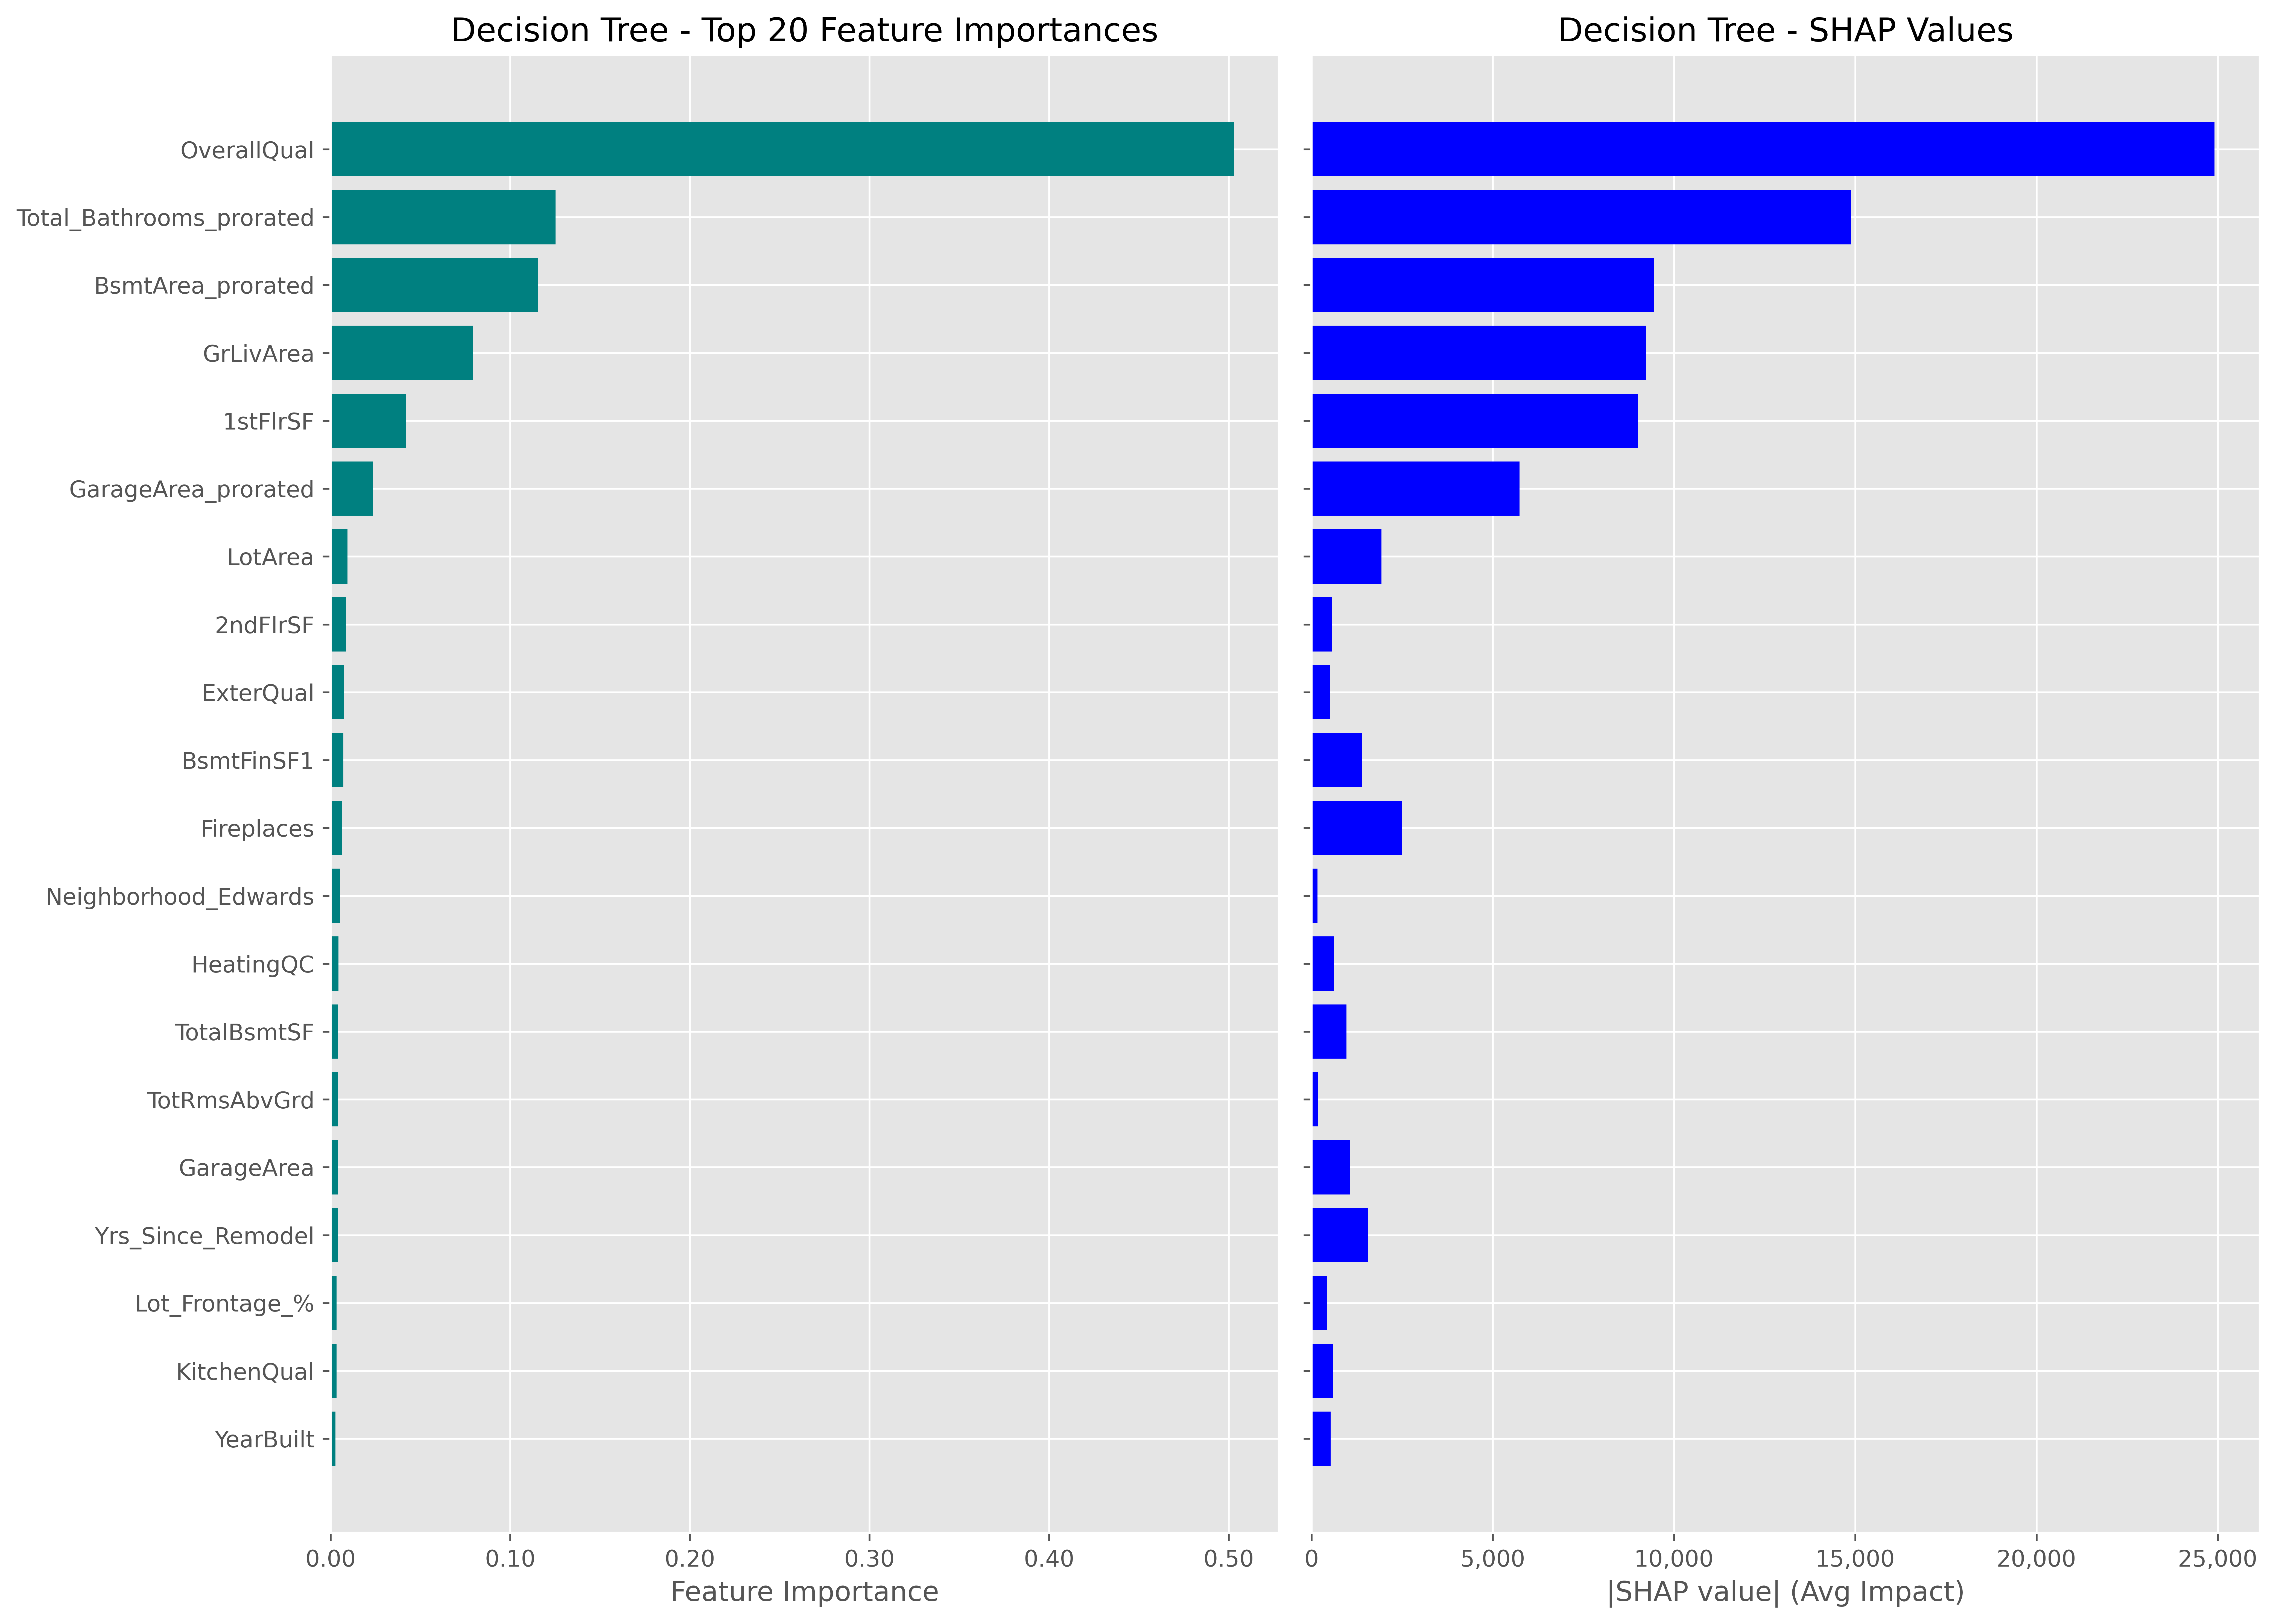

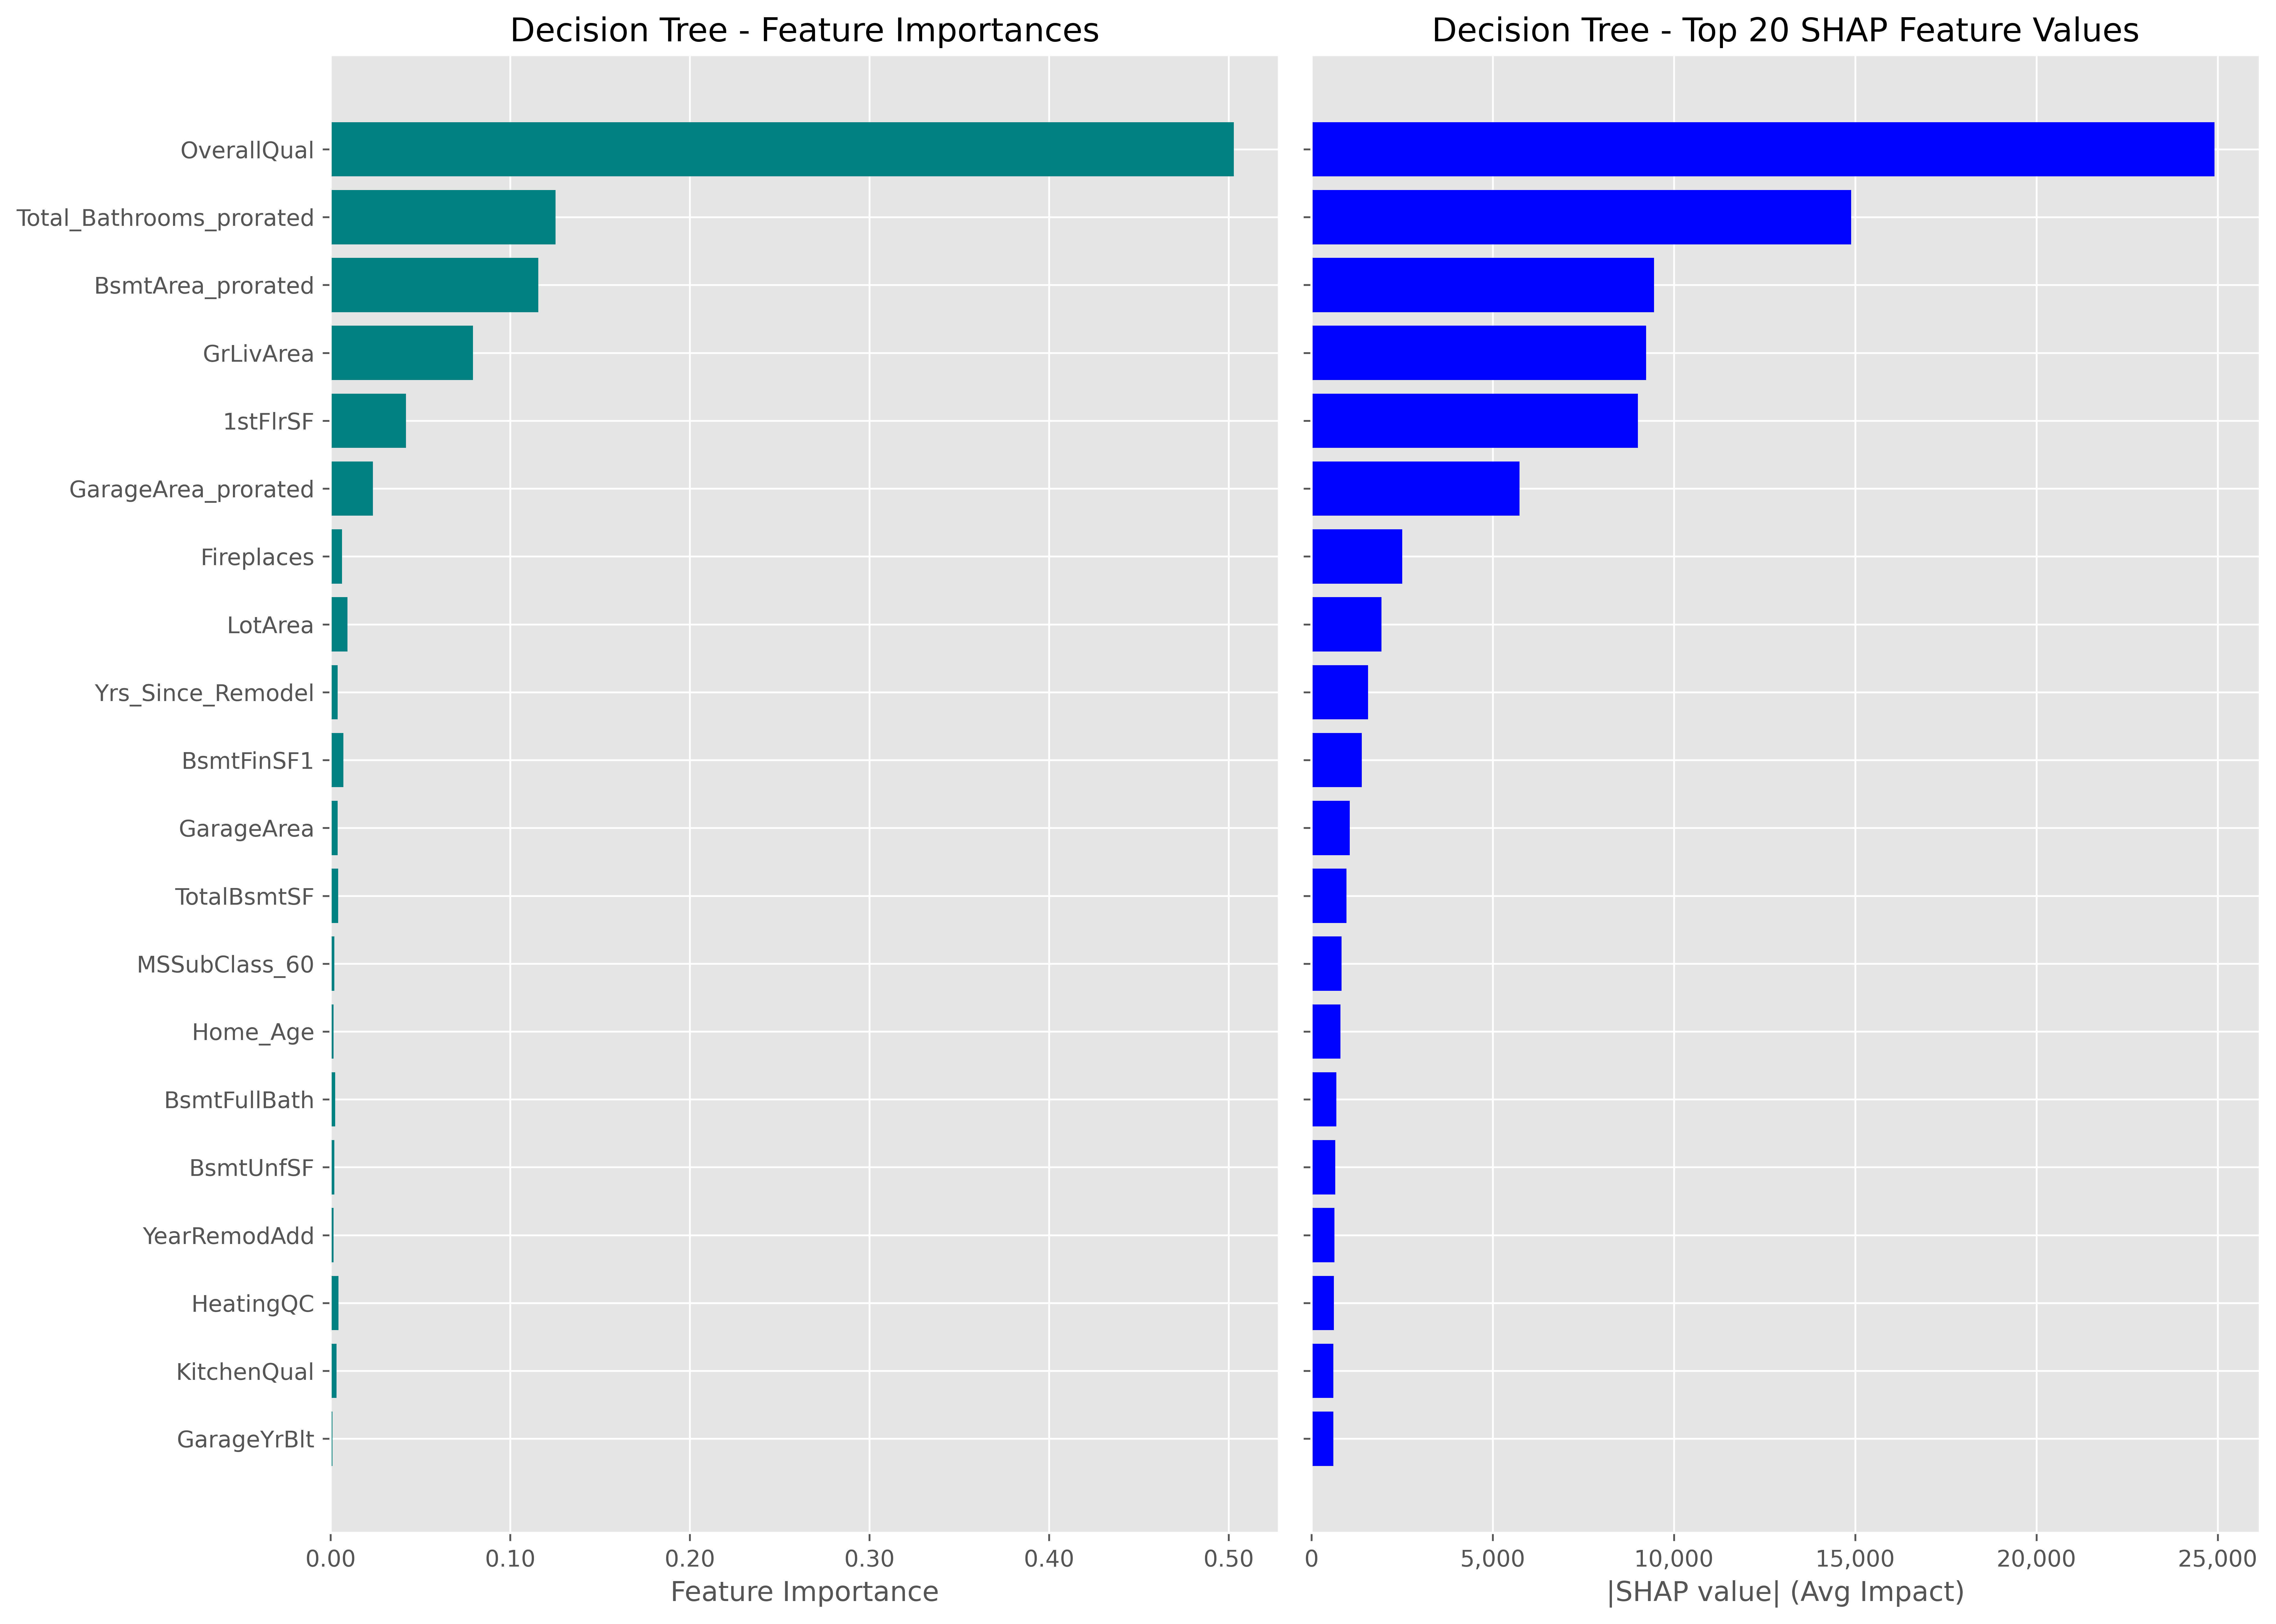


SHAP Beeswarm Plot for Decision Tree...


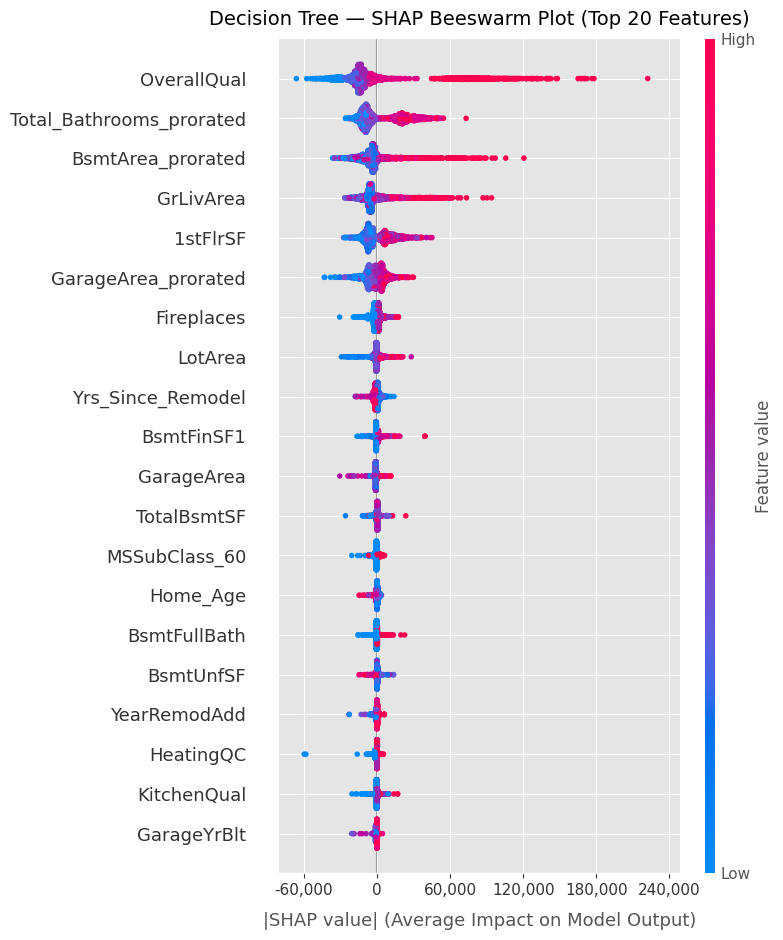

In [9]:
#Decision Tree Regressor Feature Importances & SHAP values
Plot_Feature_SHAP_Importances(grid_search_tree, 'Decision Tree')

In [48]:
bag_basic = cross_val_score(BaggingRegressor(random_state=2), X, Y, cv=5, scoring='r2')
print('Bagging Base Model Score:', float(bag_basic.mean()))

Bagging Base Model Score: 0.8835513427496207


In [49]:
'''
base_tree = DecisionTreeRegressor(random_state=2)
bagging_model = BaggingRegressor(estimator=base_tree, random_state=2, n_jobs=-1)
'''

In [ ]:
#Initial Bagging RandomizedSearchCV for faster estimates
'''
bagging_param = {
    'estimator__criterion': ['squared_error'],
    'estimator__max_depth': [21, 22, 23],
    'n_estimators': [75, 76, 77]
}
random_search_bag = RandomizedSearchCV(
    bagging_model,
    param_distributions=bagging_param,
    n_iter=20,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=2,
    verbose=1
)
random_search_bag.fit(X, Y)
print('Best parameters:', random_search_bag.best_params_)
print(f'Best CV Score: {random_search_bag.best_score_:.4f}')
'''

In [ ]:
#Final Bagging Grid Search
'''
grid_params_bagging = {
    'estimator__criterion': ['squared_error'],
    'estimator__max_depth': [21, 22, 23],
    'n_estimators': [70, 71, 72]
}
grid_search_bagging = GridSearchCV(
    estimator=bagging_model,
    param_grid=grid_params_bagging,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)
grid_search_bagging.fit(X, Y)

print('Best parameters:', grid_search_bagging.best_params_)
print(f'Best CV Score: {grid_search_bagging.best_score_:.4f}')
'''

In [ ]:
#Bagging Feature Importances & SHAP values
'''
Plot_Feature_SHAP_Importances(random_search_bag, 'Bagging')
'''

In [ ]:
#Base Random Forest Model 
'''
rf_model = RandomForestRegressor(random_state=2, n_jobs=-1)
rf_model.fit(X, Y)
'''

In [15]:
'''
print('Random Forest Base Model Score:', float(cross_val_score(rf_model, X, Y).mean()))
'''

0.8951755258558339

In [ ]:
#Initial Random Forest RandomizedSearchCV for faster estimates
'''
rf_param = {
    'criterion': ['friedman_mse'],
    'max_depth': range(21, 27),
    'n_estimators': range(156, 224),
    'max_features': ['sqrt']
}
random_search_rf = RandomizedSearchCV(
    rf_model,
    param_distributions=rf_param,
    n_iter=20,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=2,
    verbose=1
)
random_search_rf.fit(X, Y)
print('Best parameters:', random_search_rf.best_params_)
print(f'Best CV Score: {random_search_rf.best_score_:.4f}')
'''

In [ ]:
#Final Random Forest Grid Search
'''
rf_param = {
    'criterion': ['friedman_mse'],
    'max_depth': range(21, 28),
    'n_estimators': range(180, 205),
    'max_features': ['sqrt']
}
grid_search_rf = GridSearchCV(
    estimator=rf_model,
    param_grid=rf_param,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)
grid_search_rf.fit(X, Y)
print('Best parameters:', grid_search_rf.best_params_)
print(f'Best CV Score: {grid_search_rf.best_score_:.4f}')
'''

In [ ]:
#Random Forest Feature Importances & SHAP values
'''
Plot_Feature_SHAP_Importances(random_search_rf, 'Random Forest')
'''

In [50]:
#Gradient Boosting
gbm = GradientBoostingRegressor(random_state=2, verbose=1)
gbm.fit(X, Y)

      Iter       Train Loss   Remaining Time 
         1  4843471583.3372            3.92s
         2  4187814071.7748            3.62s
         3  3628548906.4580            3.48s
         4  3154005036.5787            3.09s
         5  2769702652.5875            2.90s
         6  2442179543.0286            2.86s
         7  2164869263.7938            2.97s
         8  1914067248.3381            2.85s
         9  1711948528.1577            2.78s
        10  1539849599.9676            2.70s
        20   681937040.1456            2.09s
        30   439110587.2403            1.88s
        40   336040797.6019            1.61s
        50   290063542.3846            1.30s
        60   261330667.9228            1.06s
        70   241928125.8297            0.82s
        80   225051598.1126            0.54s
        90   211783415.7680            0.27s
       100   200723237.6262            0.00s


GradientBoostingRegressor(random_state=2, verbose=1)

In [51]:
print('GradientBoosting Base Model Score:', float(cross_val_score(gbm, X, Y).mean()))

      Iter       Train Loss   Remaining Time 
         1  4530142350.4411            2.44s
         2  3900733492.8403            2.81s
         3  3376976707.1943            2.77s
         4  2941963778.8107            2.68s
         5  2580589489.0629            2.75s
         6  2261423428.2999            3.04s
         7  1989749203.4758            2.94s
         8  1761495924.0320            2.78s
         9  1560101095.8093            2.70s
        10  1397688674.7512            2.59s
        20   578449299.2409            1.88s
        30   357069312.6459            1.66s
        40   276493638.7344            1.35s
        50   236846645.4681            1.07s
        60   213805158.4160            0.82s
        70   196793267.0898            0.59s
        80   182222913.5418            0.39s
        90   170880125.7837            0.20s
       100   160213964.5564            0.00s
      Iter       Train Loss   Remaining Time 
         1  4570533376.7268            1.65s
        

In [54]:
#Initial Gradient Boosting RandomizedSearchCV for faster estimates
gbm_param = {
    'learning_rate': [0.024210526315789474],
    'subsample': [.55, .625],
    'max_depth': range(18, 24),
    'n_estimators': range(171, 181),
    'criterion': ['friedman_mse'],
    'max_features': ['sqrt']
}
random_search_gbm = RandomizedSearchCV(
    estimator=gbm,
    param_distributions=gbm_param,
    n_iter=20,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=2,
    verbose=1
)
random_search_gbm.fit(X, Y)
print('Best parameters:', random_search_gbm.best_params_)
print(f'Best CV Score: {random_search_gbm.best_score_:.4f}')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
      Iter       Train Loss      OOB Improve   Remaining Time 
         1  5574367353.1289   220554077.4564            3.93s
         2  5251276737.5739   121088198.7017            4.05s
         3  4986112240.7949   178764617.9459            3.38s
         4  4679956905.8942   101874206.6900            2.97s
         5  4544238359.6955   299267925.4377            2.75s
         6  4313751101.3065   154237607.0732            2.69s
         7  4258852479.2869   365805614.3722            2.42s
         8  3882920765.7072   -56864593.3598            2.26s
         9  3799654396.9215   285295974.5659            2.12s
        10  3708627653.1859   246825855.4171            2.20s
        20  2335959543.2388   134585332.0551            1.79s
        30  1572253130.0379   372329864.2767            1.49s
        40   910771401.7510     8800703.1732            1.37s
        50   625940096.1473    89449026.8106            1.20s
       

In [ ]:
#Gradient Boosting Feature Importances & SHAP values
'''
Plot_Feature_SHAP_Importances(random_search_gbm, 'Gradient Boosting Regressor')
'''

In [10]:
#Hist Gradient Boosting Base Model
hgbm = HistGradientBoostingRegressor(random_state=2, verbose=1)
hgbm.fit(X, Y)

Binning 0.005 GB of training data: 0.053 s
Fitting gradient boosted rounds:
Fit 100 trees in 4.981 s, (3100 total leaves)
Time spent computing histograms: 1.003s
Time spent finding best splits:  0.088s
Time spent applying splits:      0.061s
Time spent predicting:           0.003s


HistGradientBoostingRegressor(random_state=2, verbose=1)

In [11]:
print('HistGradientBoosting Base Model Score:', float(cross_val_score(hgbm, X, Y).mean()))

Binning 0.004 GB of training data: 0.079 s
Fitting gradient boosted rounds:
Fit 100 trees in 1.398 s, (3100 total leaves)
Time spent computing histograms: 0.884s
Time spent finding best splits:  0.079s
Time spent applying splits:      0.056s
Time spent predicting:           0.003s
Binning 0.004 GB of training data: 0.055 s
Fitting gradient boosted rounds:
Fit 100 trees in 1.321 s, (3100 total leaves)
Time spent computing histograms: 0.866s
Time spent finding best splits:  0.074s
Time spent applying splits:      0.053s
Time spent predicting:           0.003s
Binning 0.004 GB of training data: 0.059 s
Fitting gradient boosted rounds:
Fit 100 trees in 1.375 s, (3100 total leaves)
Time spent computing histograms: 0.889s
Time spent finding best splits:  0.079s
Time spent applying splits:      0.056s
Time spent predicting:           0.003s
Binning 0.004 GB of training data: 0.065 s
Fitting gradient boosted rounds:
Fit 100 trees in 1.348 s, (3100 total leaves)
Time spent computing histograms:

In [12]:
#Initial Hist Gradient Boosting RandomizedSearchCV for faster estimates
hgbm_param = {
    'learning_rate': np.linspace(.01, .2, 20),
    'max_leaf_nodes': [11, 12],
    'max_iter': [300, 375, 450],
    'min_samples_leaf': [11, 12],
    #'l2_regularization': [0.0, 0.1, 0.5, 1.0],
}
random_search_hgb = RandomizedSearchCV(
    estimator=hgbm,
    param_distributions=hgbm_param,
    n_iter=20,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=2,
    verbose=1
)
random_search_hgb.fit(X, Y)
print('Best parameters:', random_search_hgb.best_params_)
print(f'Best CV Score: {random_search_hgb.best_score_:.4f}')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Binning 0.005 GB of training data: 0.044 s
Fitting gradient boosted rounds:
Fit 375 trees in 1.918 s, (4125 total leaves)
Time spent computing histograms: 1.189s
Time spent finding best splits:  0.142s
Time spent applying splits:      0.076s
Time spent predicting:           0.008s
Best parameters: {'min_samples_leaf': 11, 'max_leaf_nodes': 11, 'max_iter': 375, 'learning_rate': np.float64(0.060000000000000005)}
Best CV Score: 0.9209


Calculating permutation importances for HistGradientBoostingRegressor...
Calculating SHAP values for HistGradientBoostingRegressor...


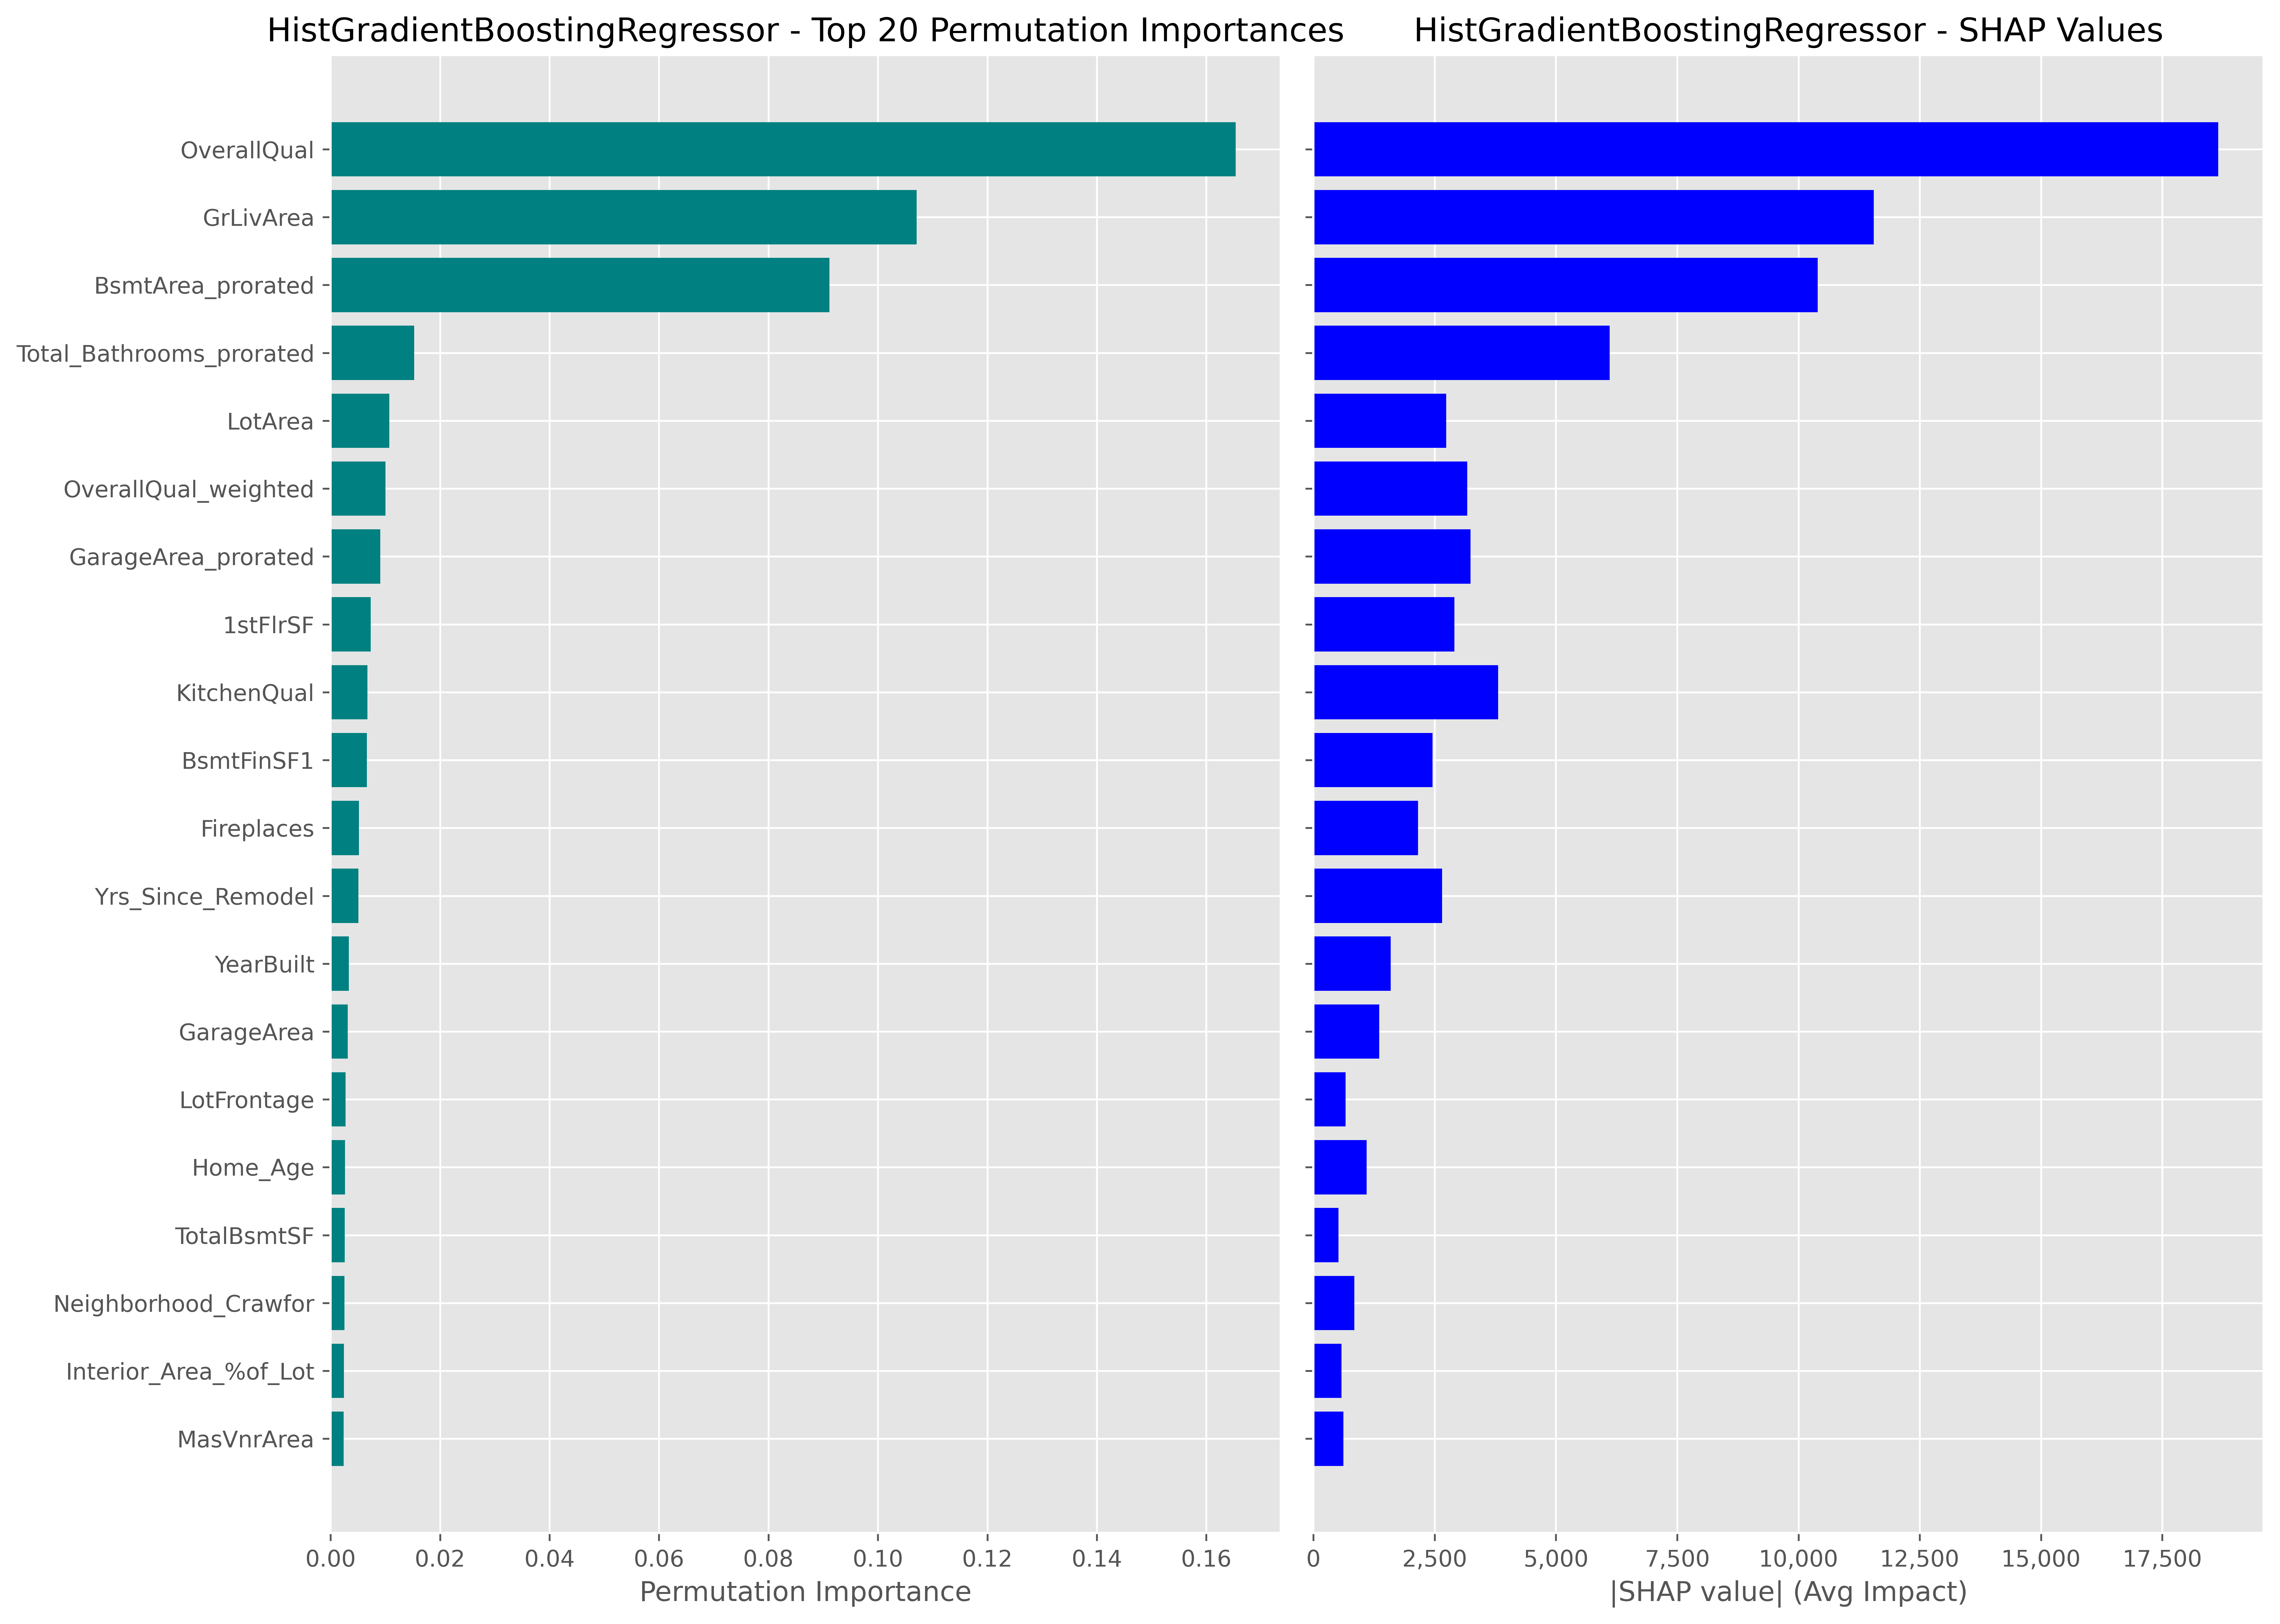

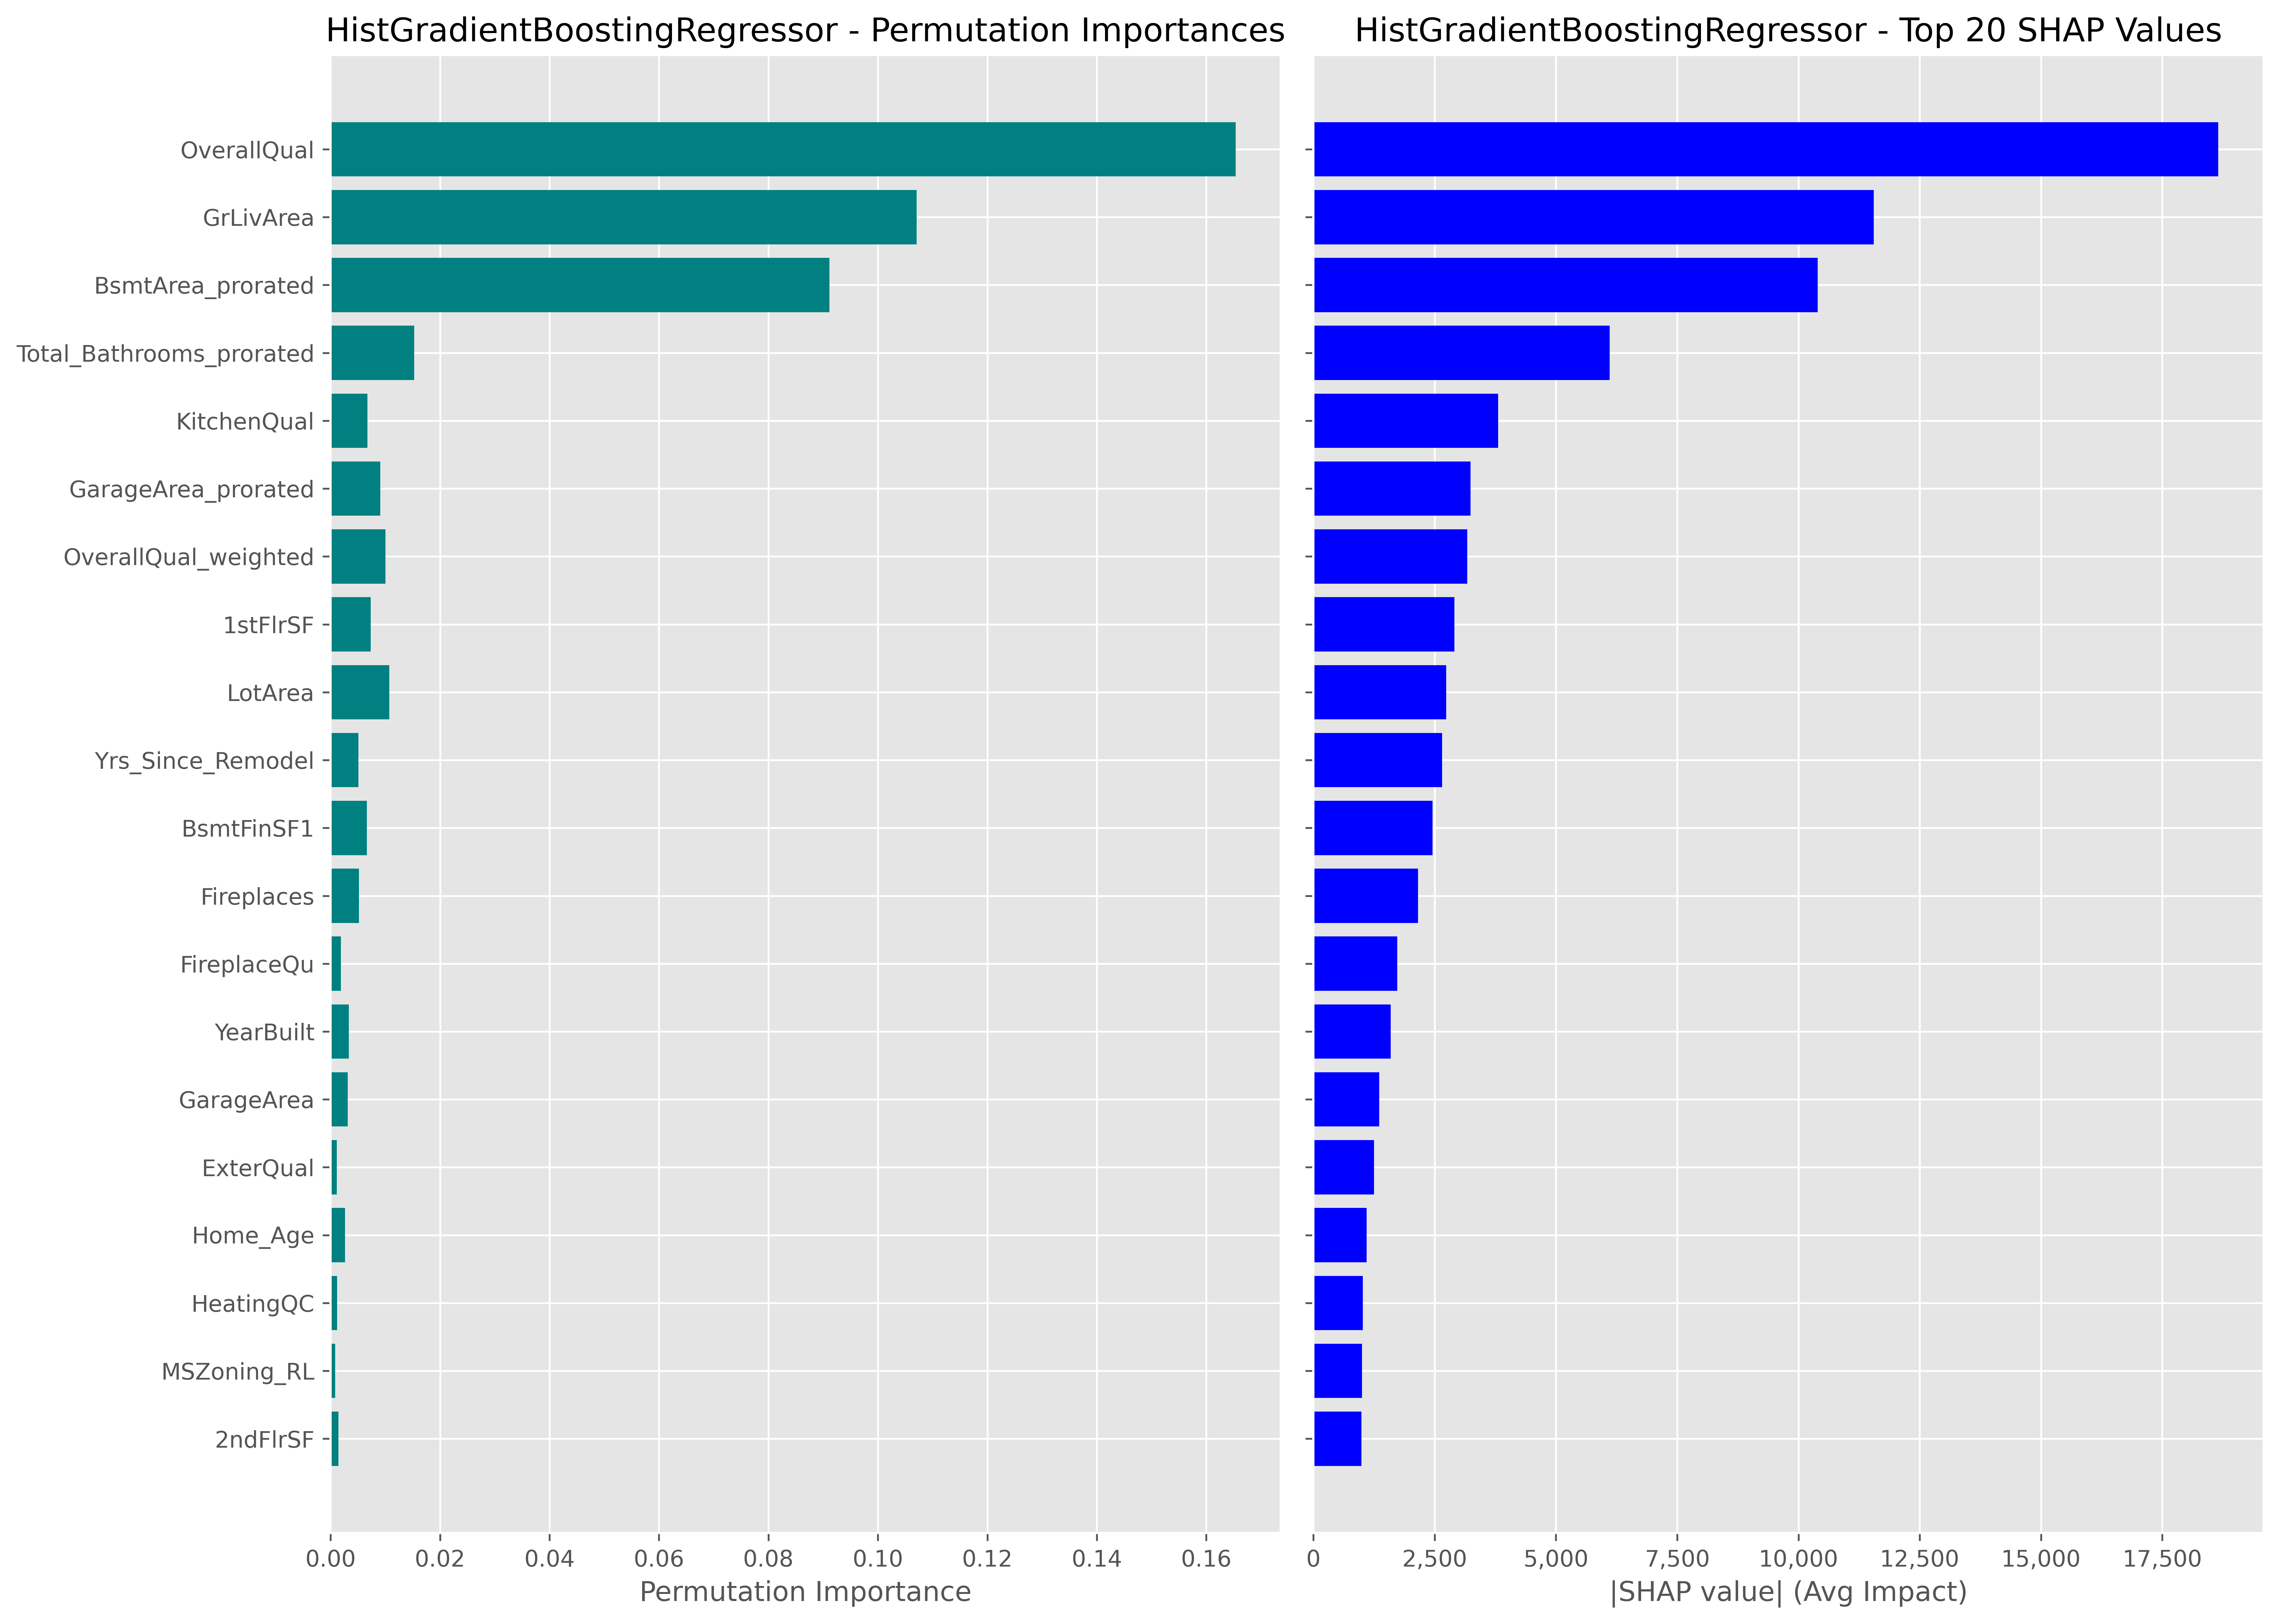


SHAP Beeswarm Plot for HistGradientBoostingRegressor...


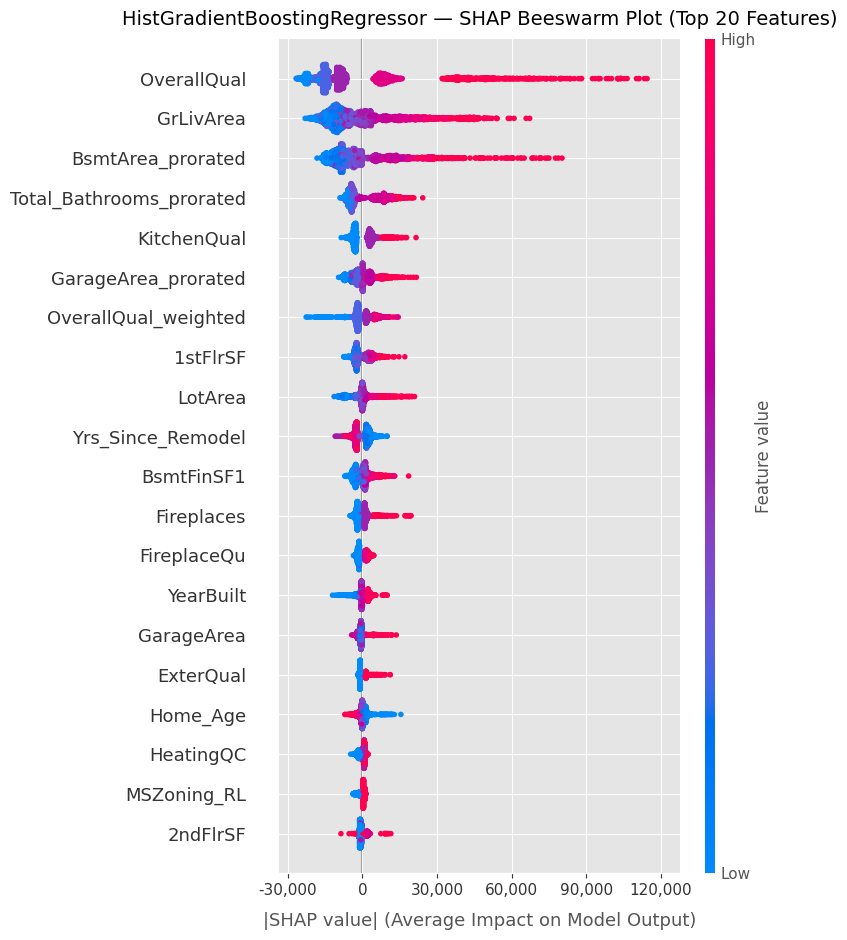

In [13]:
#Hist Gradient Boosting Regressor Feature Importances & SHAP values
Plot_HGB_Feature_SHAP_Importances(random_search_hgb)

In [10]:
#Base XGBoost Model
xgbm = XGBRegressor(random_state=2, n_jobs=-1, verbosity=1, booster='gbtree')
xgbm.fit(X, Y)

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=-1, num_parallel_tree=None, ...)

In [11]:
print('XGBoost Base Model Score:', float(cross_val_score(xgbm, X, Y).mean()))

XGBoost Base Model Score: 0.8973777651786804


In [12]:
#Initial XGBoost RandomizedSearchCV for faster estimates
xgbm_param = {
    'learning_rate': np.linspace(0.01, 0.1, 11),
    'subsample': np.linspace(0.7, 1, 4),
    'colsample_bytree': np.linspace(0.7, 1, 4),
    'max_depth': range(2, 11),
    'n_estimators': range(210, 260),
    'min_child_weight': range(1, 11),
    'gamma': [0, 0.1, 0.2],
    'reg_lambda': np.linspace(0, 1, 5),
    'reg_alpha': np.linspace(0, 1, 5),
}
random_search_xgbm = RandomizedSearchCV(
    estimator=xgbm,
    param_distributions=xgbm_param,
    n_iter=20,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=2,
    verbose=1
)
random_search_xgbm.fit(X, Y)
print('Best parameters:', random_search_xgbm.best_params_)
print(f'Best CV Score: {random_search_xgbm.best_score_:.4f}')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'subsample': np.float64(0.7), 'reg_lambda': np.float64(0.5), 'reg_alpha': np.float64(0.75), 'n_estimators': 255, 'min_child_weight': 3, 'max_depth': 4, 'learning_rate': np.float64(0.046000000000000006), 'gamma': 0.2, 'colsample_bytree': np.float64(0.9)}
Best CV Score: 0.9192


PermutationExplainer explainer: 2580it [03:41, 11.34it/s]                                                              



SHAP Beeswarm Plot for XGBoost...


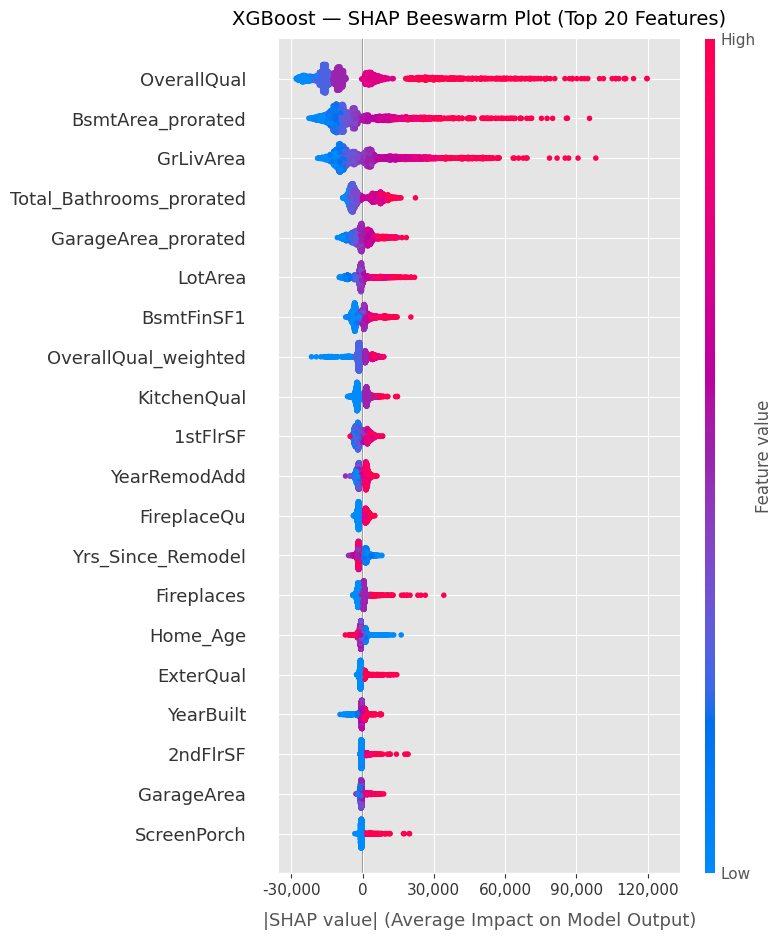

In [13]:
#XGBoost Feature Importances & SHAP values
Plot_Feature_SHAP_Importances(random_search_xgbm, 'XGBoost')

In [14]:
#Base LightGBM Model
lgbm = LGBMRegressor(random_state=2, verbose=1, n_jobs=-1)
lgbm.fit(X, Y)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5686
[LightGBM] [Info] Number of data points in the train set: 2579, number of used features: 185
[LightGBM] [Info] Start training from score 178053.442420


LGBMRegressor(n_jobs=-1, random_state=2, verbose=1)

In [77]:
print('LightGBM Base Model Score:', float(cross_val_score(lgbm, X, Y).mean()))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5622
[LightGBM] [Info] Number of data points in the train set: 2063, number of used features: 177
[LightGBM] [Info] Start training from score 177061.364033
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5636
[LightGBM] [Info] Number of data points in the train set: 2063, number of used features: 176
[LightGBM] [Info] Start training from score 177182.857974
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the over

In [16]:
#Initial LightGBM RandomizedSearchCV for faster estimates
lgbm_param = {
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'min_child_samples': [10, 20, 30],
    'num_leaves': [15, 31, 63, 127],
    'max_depth': [1, 50, 99],
    'n_estimators': range(150, 250),
    'reg_lambda': [0.0, 0.1, 0.5, 1.0],
    'reg_alpha': [0.0, 0.1, 0.5]
}
random_search_lgbm = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=lgbm_param,
    n_iter=20,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=2,
    verbose=1
)
random_search_lgbm.fit(X, Y)
print('Best parameters:', random_search_lgbm.best_params_)
print(f'Best CV Score: {random_search_lgbm.best_score_:.4f}')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5686
[LightGBM] [Info] Number of data points in the train set: 2579, number of used features: 185
[LightGBM] [Info] Start training from score 178053.442420
Best parameters: {'subsample': 1.0, 'reg_lambda': 1.0, 'reg_alpha': 0.1, 'num_leaves': 15, 'n_estimators': 165, 'min_child_samples': 20, 'max_depth': 50, 'learning_rate': 0.05, 'colsample_bytree': 0.7}
Best CV Score: 0.9192


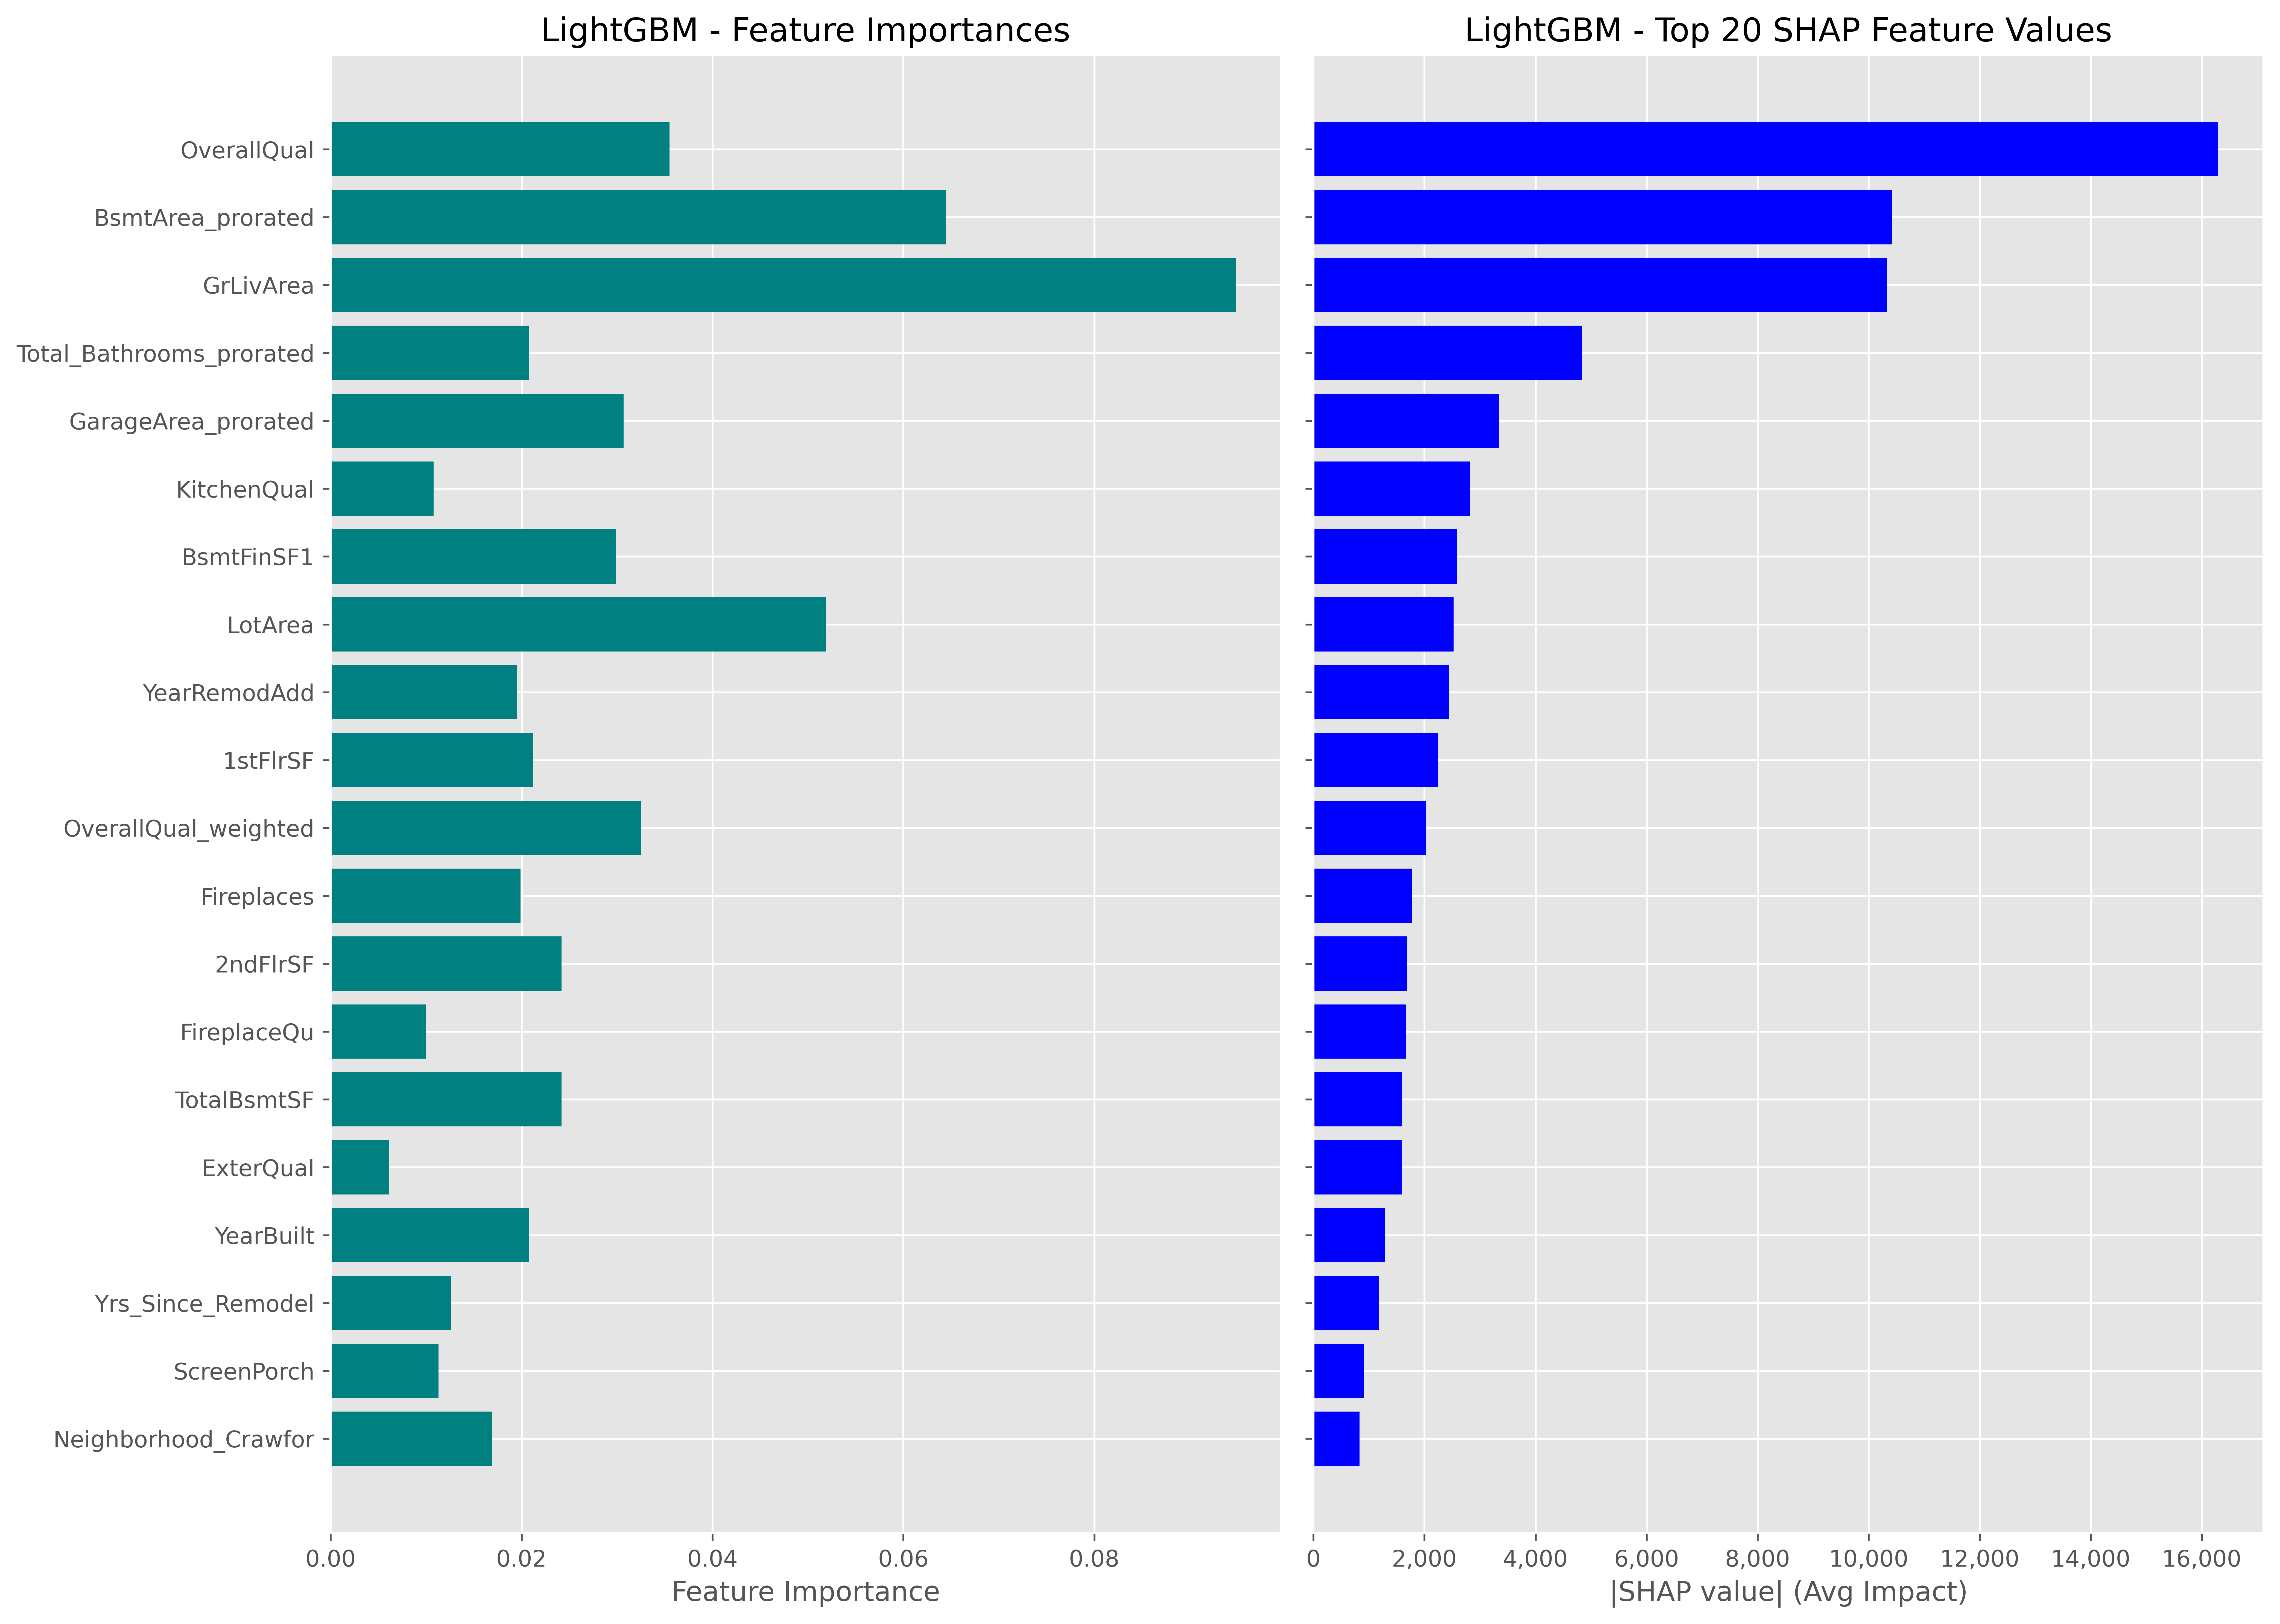


SHAP Beeswarm Plot for LightGBM...


In [17]:
#LightGBM Feature Importances & SHAP values
Plot_Feature_SHAP_Importances(random_search_lgbm, 'LightGBM')

In [18]:
#Base CatBoost Model
cat_boost = CatBoostRegressor(random_state=2, verbose=0, thread_count=-1)
cat_boost.fit(X, Y)

In [9]:
print('CatBoost Base Model Score:', float(cross_val_score(cat_boost, X, Y).mean()))

CatBoost Base Model Score: 0.931268347079105


In [19]:
#Initial CatBoost RandomizedSearchCV for faster estimates
cat_boost_param = {
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bylevel': [0.7, 0.8, 0.9, 1.0],
    'min_data_in_leaf': [10, 20, 30],
    'depth': [4, 6, 8, 10],
    'iterations': range(150, 250),
    'l2_leaf_reg': [0.0, 0.1, 0.5, 1.0]
}
random_search_cat = RandomizedSearchCV(
    estimator=cat_boost,
    param_distributions=cat_boost_param,
    n_iter=20,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=2,
    verbose=1
)
random_search_cat.fit(X, Y)
print('Best parameters:', random_search_cat.best_params_)
print(f'Best CV Score: {random_search_cat.best_score_:.4f}')

Best parameters: {'subsample': 0.9, 'min_data_in_leaf': 10, 'learning_rate': 0.05, 'l2_leaf_reg': 0.1, 'iterations': 236, 'depth': 6, 'colsample_bylevel': 0.8}
Best CV Score: 0.9245


 99%|===================| 2552/2579 [00:46<00:00]        

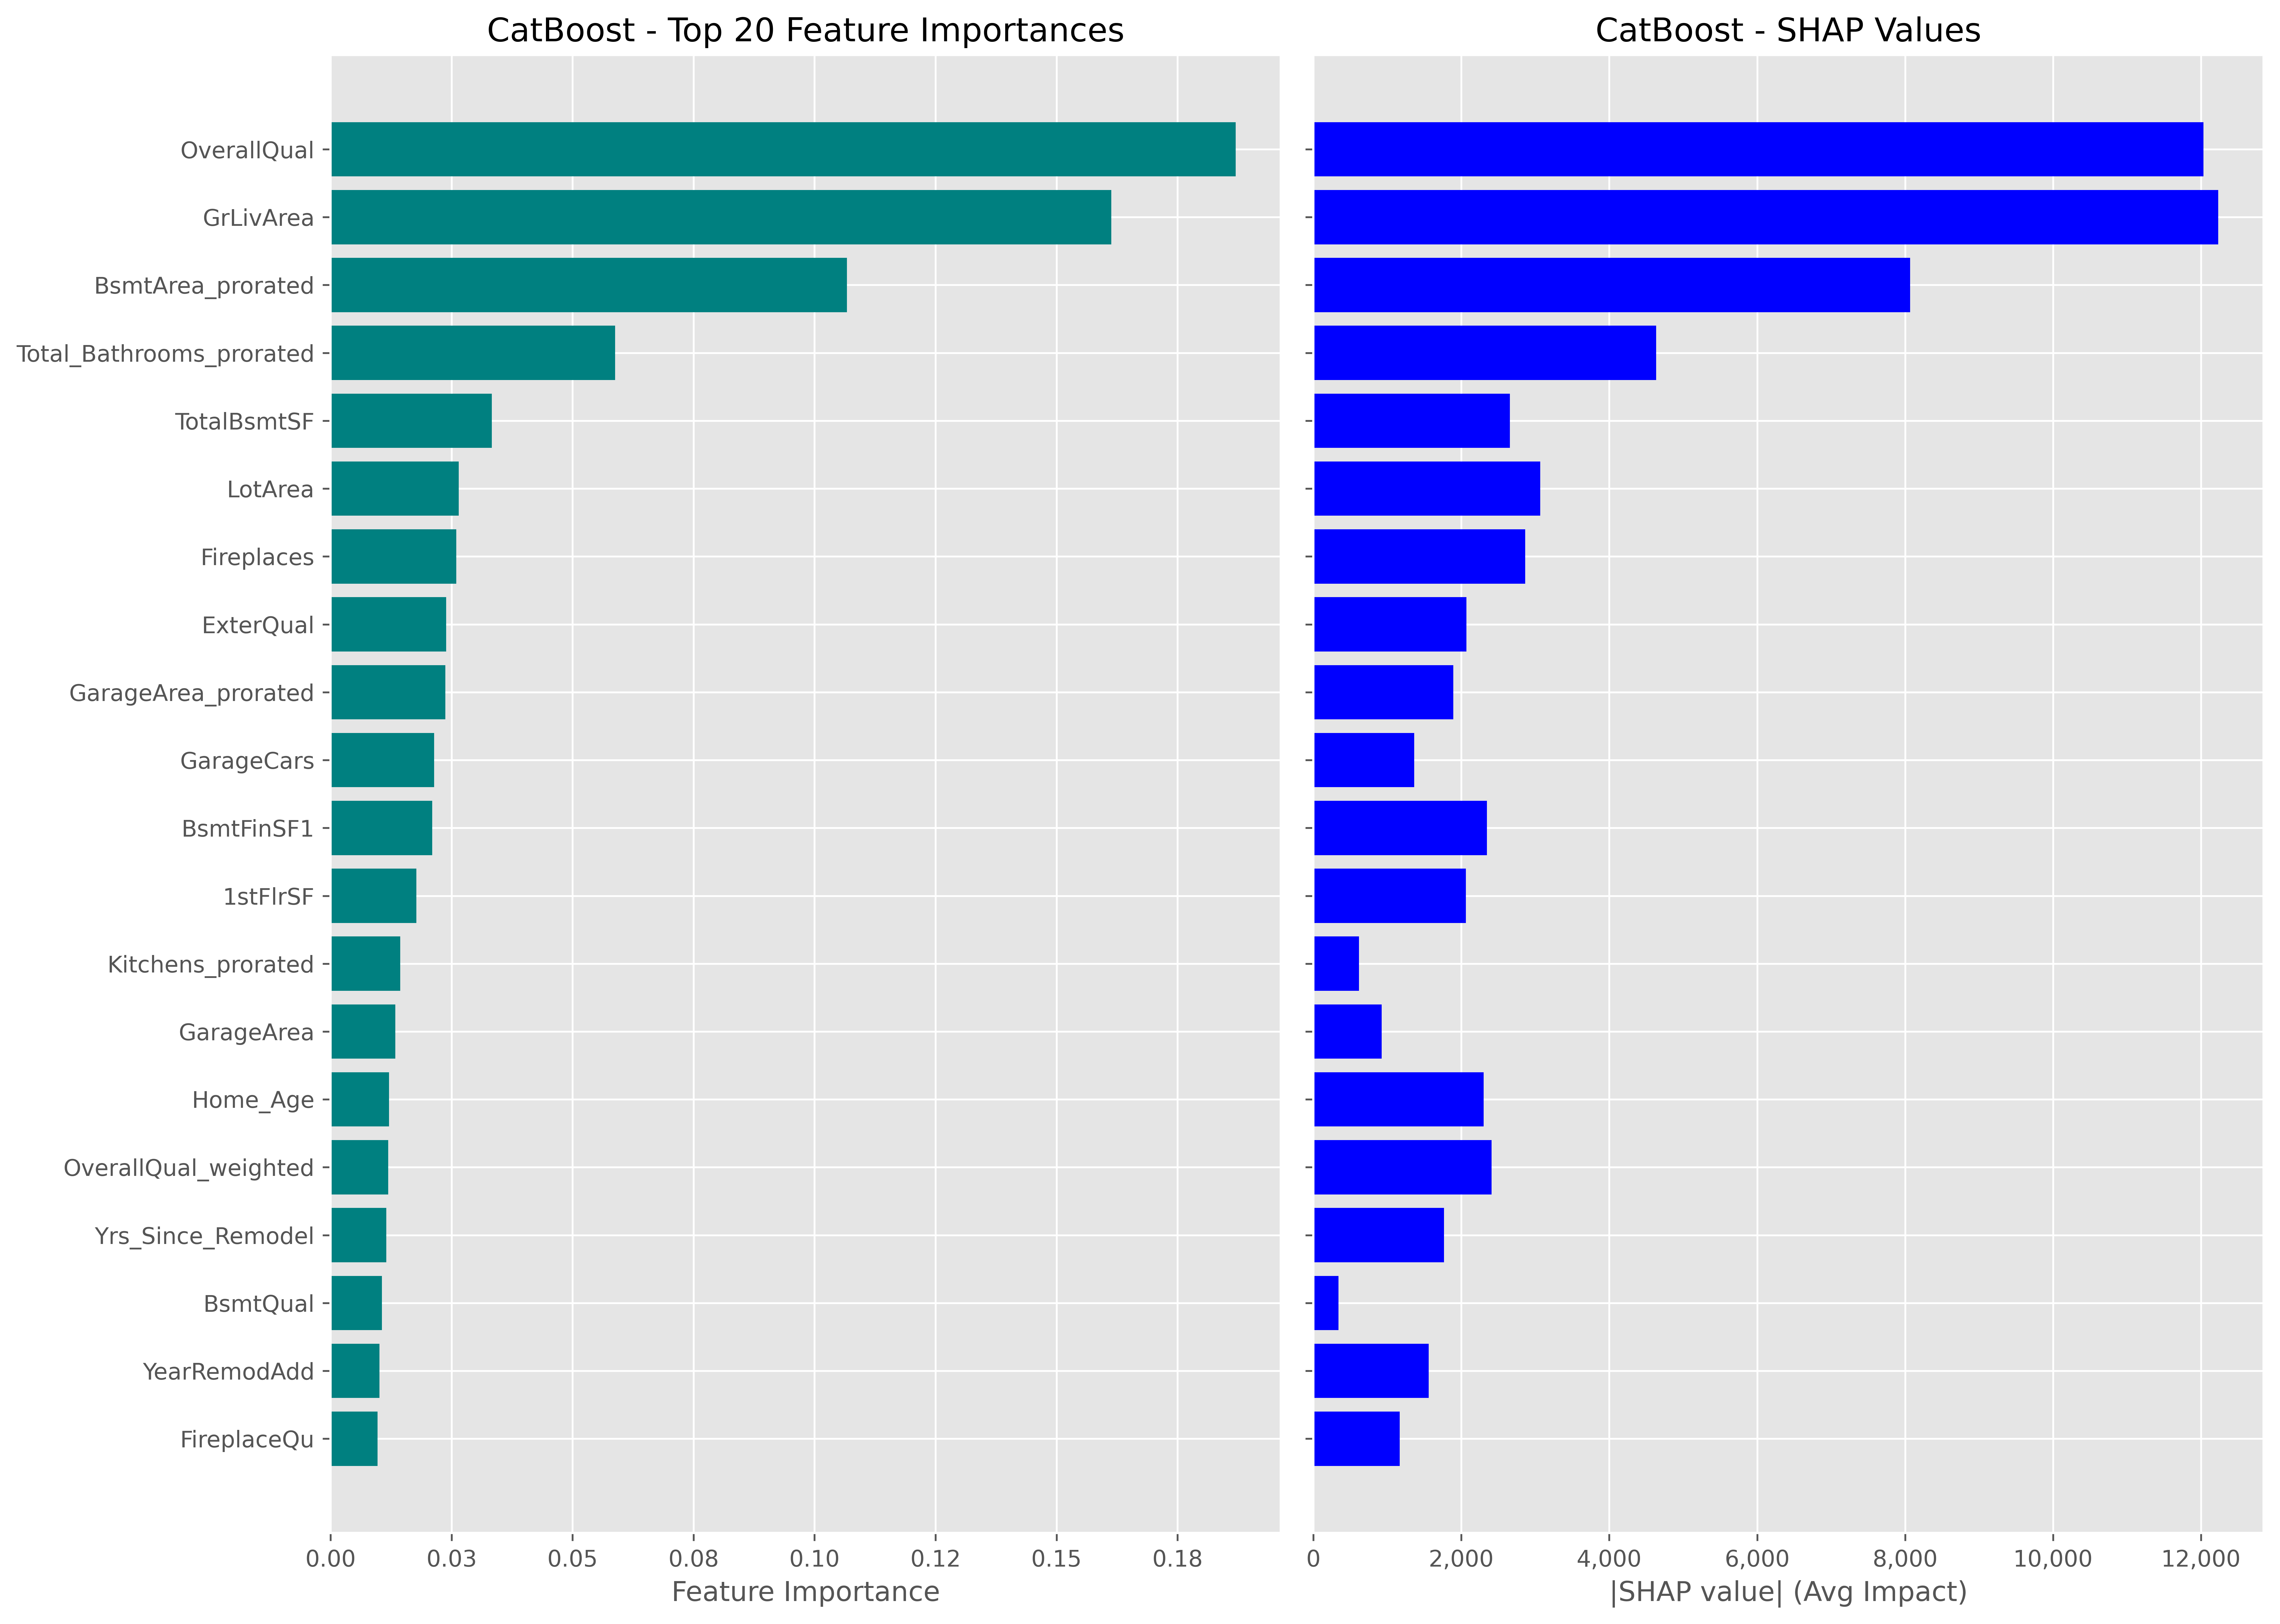


SHAP Beeswarm Plot for CatBoost...


In [20]:
#CatBoost Feature Importances & SHAP values
Plot_Feature_SHAP_Importances(cat_boost, 'CatBoost')

In [ ]:
#Base AdaBoost Model
'''
adaBoost = AdaBoostRegressor(estimator = tree_model, random_state=2)
adaBoost.fit(X, Y)
'''

In [ ]:
'''
print('AdaBoost Base Model Score:', float(cross_val_score(adaBoost, X, Y).mean()))
'''

In [61]:
#Initial AdaBoost RandomizedSearchCV for faster estimates
'''
adaBoost_param = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'estimator__max_depth': [3, 5, 7, 9, 11],
    'n_estimators': range(100, 250),
    'loss': ['linear', 'square', 'exponential']
}
random_search_adaBoost = RandomizedSearchCV(
    estimator=adaBoost,
    param_distributions=adaBoost_param,
    n_iter=20,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=2,
    verbose=1
)
random_search_adaBoost.fit(X, Y)
print('Best parameters:', random_search_adaBoost.best_params_)
print(f'Best CV Score: {random_search_adaBoost.best_score_:.4f}')
'''

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'n_estimators': 184, 'loss': 'linear', 'learning_rate': 0.2, 'estimator__max_depth': 7}
Best CV Score: 0.8893


In [ ]:
#AdaBoost Feature Importances & SHAP values
'''
Plot_Feature_SHAP_Importances(adaBoost, 'AdaBoost')
'''